In [6]:
import notebook_import
import arrhythmia.experimental.mitdb as mitdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

large_images = True

%matplotlib inline
if large_images:
    import matplotlib as mlp
    mlp.rcParams['figure.dpi'] = 300

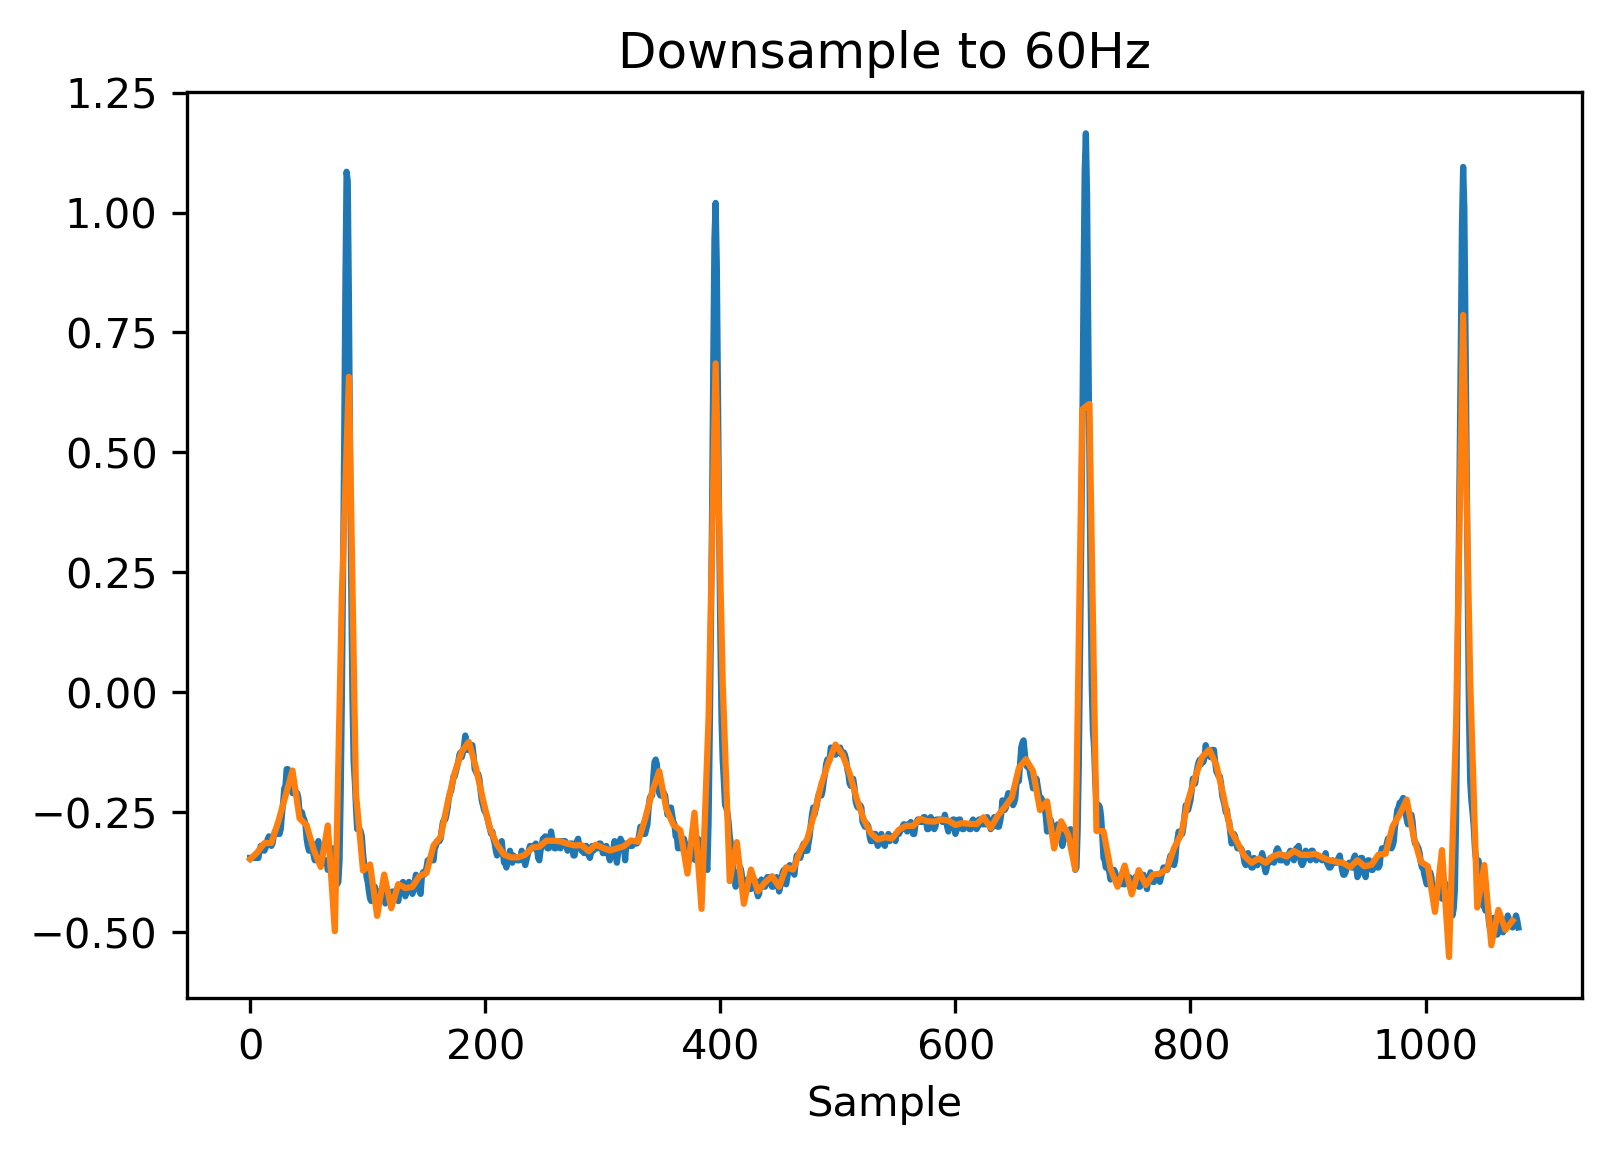

Unique label sets and their count:
[0. 0. 0.] 703
[0. 1. 0.] 565
[0. 1. 1.] 114
[1. 0. 0.] 312
[1. 0. 1.] 2
[1. 1. 0.] 228
[1. 1. 1.] 144
Total of 2068 samples


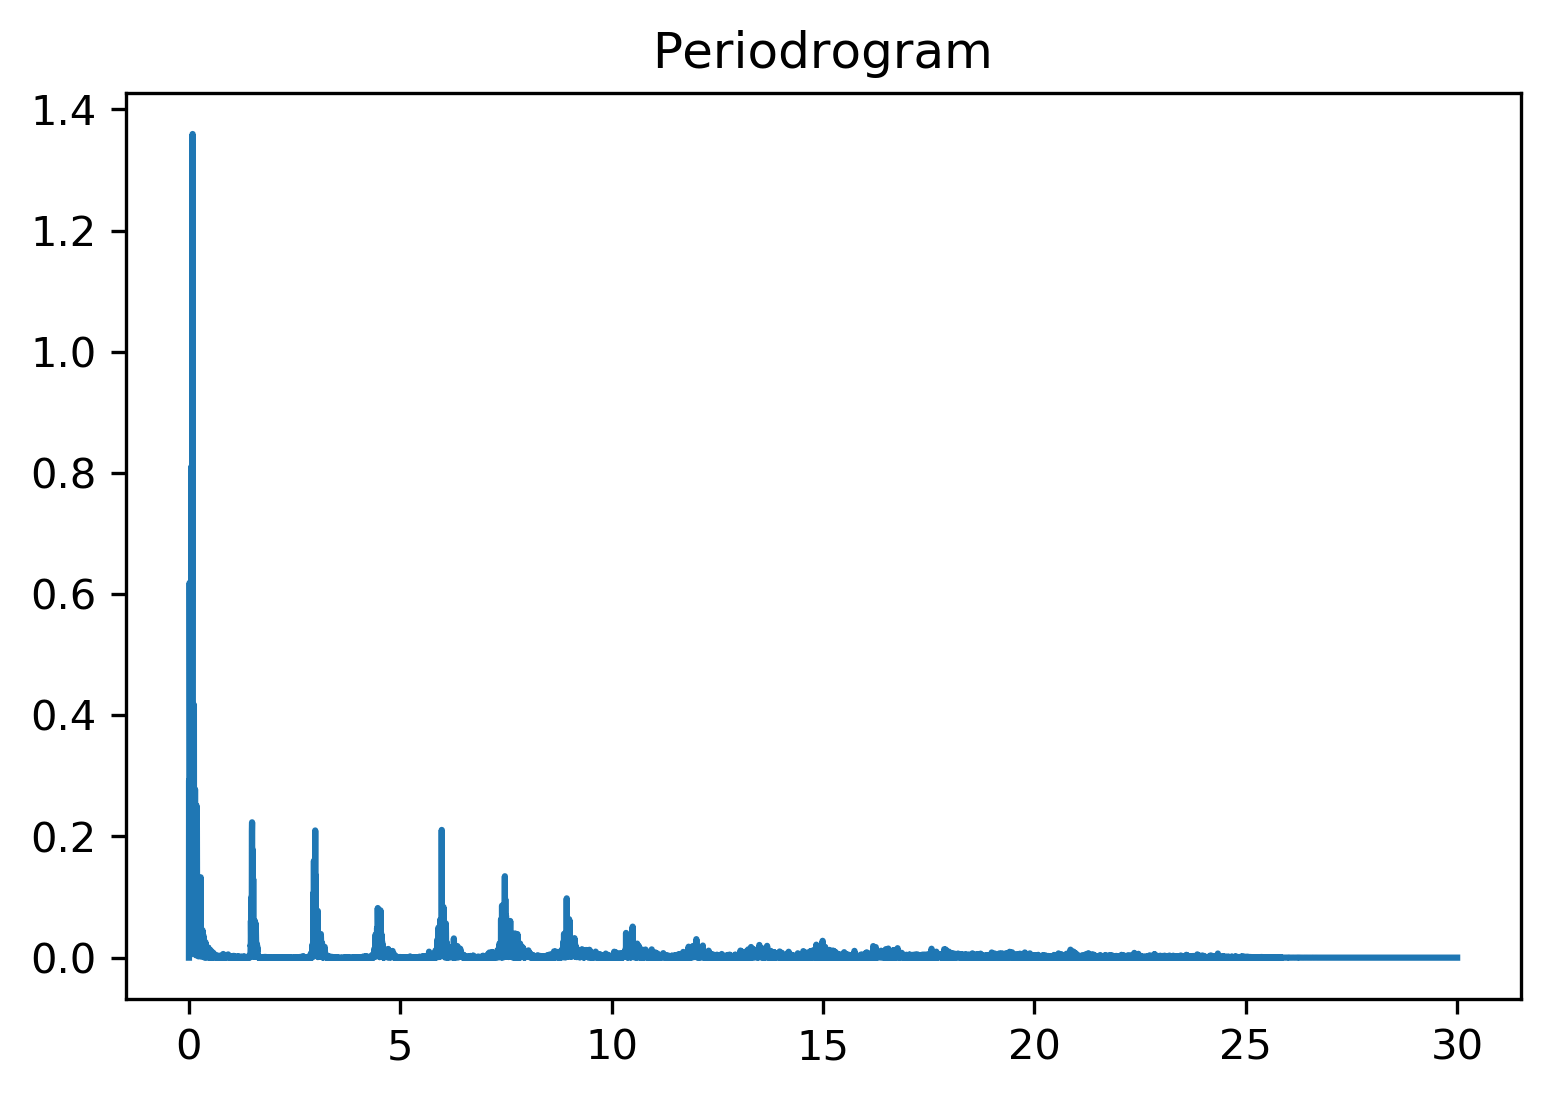

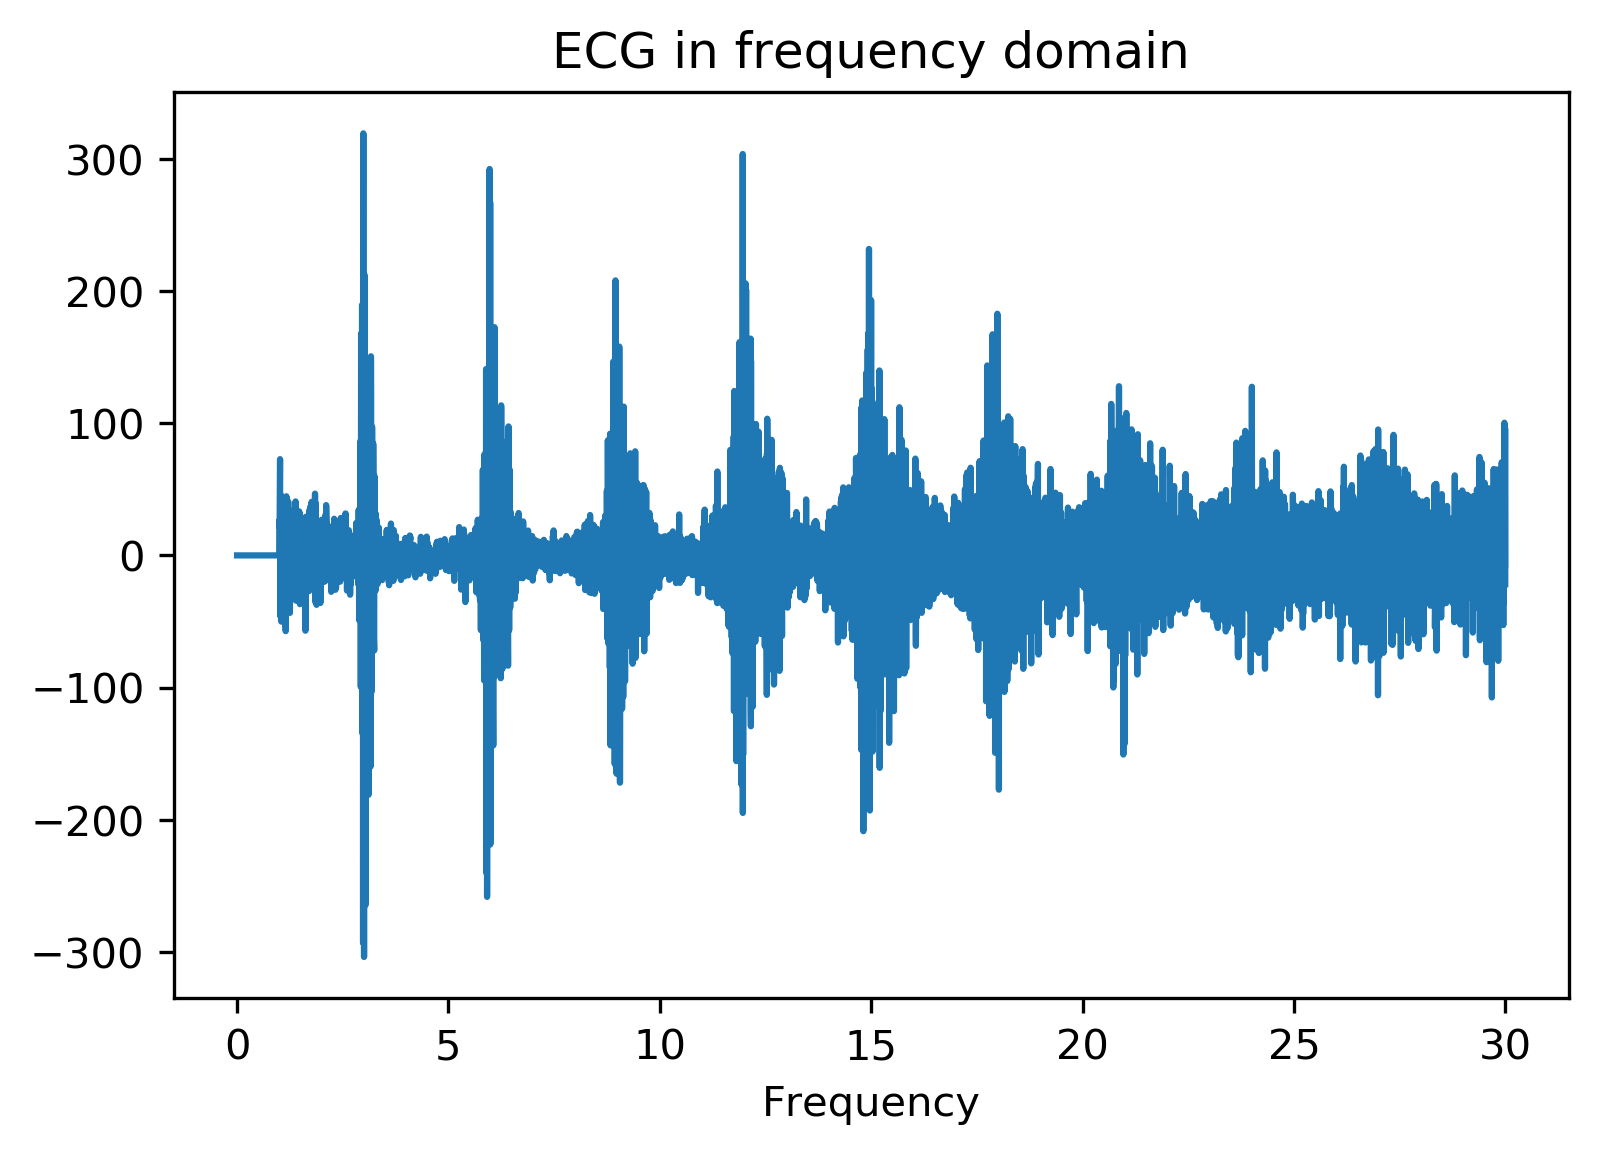

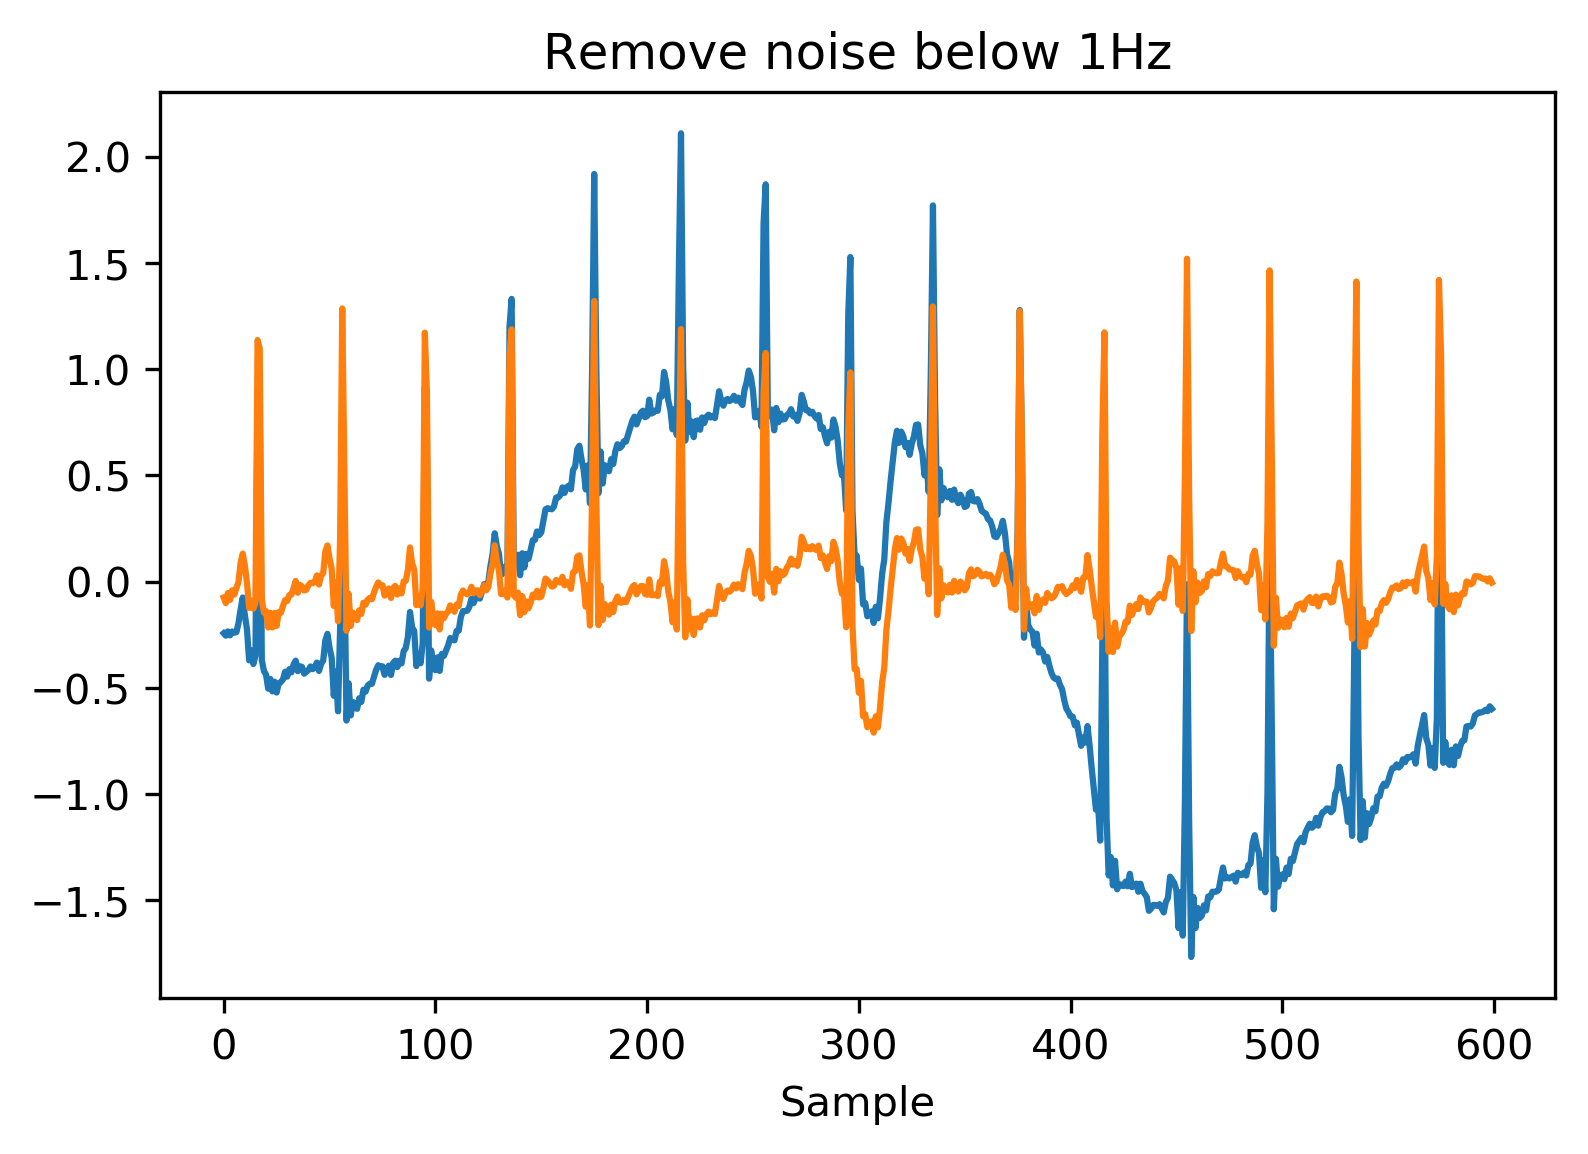

In [7]:
# Load all mitdb records
full_data = mitdb.get_records(mitdb.full_ds)

# Slice all data into time frames of size 10 min + 5 min
from arrhythmia.experimental.common import slice_records
from arrhythmia.model.helpers import beat_types
from arrhythmia.model.preprocessing import downsample

pred_minutes = 5
post_minutes = 2

pred_window = 360 * 60 * pred_minutes
post_window = 360 * 60 * post_minutes

slicer = slice_records(full_data, pred_window, post_window, increment=360 * 30, check_pred=False)

# Convert loaded data into model input and expected classes
def to_classes(labels, threshold=1):
    targets = np.zeros(len(beat_types[1:-1]), dtype=np.float32)
    for i, bt in enumerate(beat_types[1:-1]):
        count = np.sum(labels == bt.symbol)
        targets[i] = 1.0 if count >= threshold else 0.0
    return targets

# Downsample data to reduce number of features and remove high f. noise at the same time
frequency = 360
target_frequency = 60
input_data = []
classes = []
for i, (pred, post) in enumerate(slicer):
    data = pred[0]
    cl = to_classes(post[2])
    if target_frequency != frequency:
        if i == 0:
            plt.plot(data[:frequency*3])
        data = downsample(data, frequency // target_frequency)
        if i == 0:
            back_x = np.arange(0, frequency*3, frequency // target_frequency)
            plt.plot(back_x, data[:target_frequency*3])
            plt.title('Downsample to {}Hz'.format(target_frequency))
            plt.xlabel('Sample')
            plt.show()

    input_data.append(data)
    classes.append(cl)

frequency = target_frequency
        
input_data = np.array(input_data)
classes = np.array(classes)
        
unique, cnts = np.unique(classes, axis=0, return_counts=True)
print('Unique label sets and their count:')
for u, c in zip(unique, cnts):
    print(u, c)
print('Total of {} samples'.format(sum(cnts)))

# Plot periodogram
periodogram = True
if periodogram:
    from scipy.signal import periodogram
    f, pxx = periodogram(input_data[-2], frequency, return_onesided=True)
    plt.plot(f, pxx)
    plt.title('Periodrogram')
    plt.show()

# Remove low frequency noise using FFT->IFFT
fft = True
replace_with_fft = False
fft_threshold = 1
if fft:
    from scipy import fftpack
    after_fft = fftpack.rfft(input_data)

    fft_freq = fftpack.fftfreq(after_fft.shape[-1], d=1/frequency)

    after_fft[:, np.abs(fft_freq) < fft_threshold] = 0
    halfsize = after_fft.shape[1]//2
    plt.plot(fft_freq[:halfsize], after_fft[-2, :halfsize].real)
    plt.title('ECG in frequency domain')
    plt.xlabel('Frequency')
    plt.show()
    
    if not replace_with_fft:
        plt.plot(input_data[-2][:frequency*10])
        input_data = fftpack.irfft(after_fft)
        plt.plot(input_data[-2][:frequency*10])
        plt.title('Remove noise below {}Hz'.format(fft_threshold))
        plt.xlabel('Sample')
        plt.show()
    else:
        input_data = fft_freq.real

input_data = np.array(input_data)
input_shape = input_data.shape[1:]

# Normalize input data
from arrhythmia.experimental.common import normalize_mean_std

input_data_n = normalize_mean_std(input_data)

In [8]:
from arrhythmia.experimental.common import ModelTester
import keras.backend as K
# TODO Update keras to use those metrics
#from keras.metrics import precision, recall

tester = ModelTester(input_data_n, classes, verbose=0)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

metrics = ['binary_accuracy', 'mse', precision, recall, fmeasure]

window_postfix = str(pred_minutes) + '_' + str(post_minutes)
def network_name(name):
    return 'mlp_{}_f{}_fft_win_{}_{}.hdf5'.format(name, frequency, pred_minutes, post_minutes)

## Networks:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Conv1D, MaxPooling1D, Flatten


def dense_network(layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = inputs
        for layer in layers:
            x = Dense(layer, activation='relu')(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

def conv_network(pool=4, layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = Reshape((*input_shape, 1))(inputs)
        for size, num in layers:
            x = Conv1D(size, num, activation='relu')(x)
            x = MaxPooling1D(pool_size=pool)(x)
        x = Flatten()(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

Testing dense model with layers: [10, 50, 10]
Trained for 10 epochs
loss: 0.6158, binary_accuracy: 0.6755, mean_squared_error: 0.2109, precision: 0.5108, recall: 0.3106, fmeasure: 0.3688
Trained for 11 epochs
loss: 0.6016, binary_accuracy: 0.6836, mean_squared_error: 0.2052, precision: 0.5337, recall: 0.3297, fmeasure: 0.3811
Trained for 14 epochs
loss: 0.6274, binary_accuracy: 0.6385, mean_squared_error: 0.2169, precision: 0.4269, recall: 0.4601, fmeasure: 0.4230
Trained for 15 epochs
loss: 0.5887, binary_accuracy: 0.6990, mean_squared_error: 0.1995, precision: 0.5062, recall: 0.3353, fmeasure: 0.3888
Trained for 15 epochs
loss: 0.6313, binary_accuracy: 0.6554, mean_squared_error: 0.2184, precision: 0.4172, recall: 0.4050, fmeasure: 0.3970
loss: 0.6130 (+/-0.0159), binary_accuracy: 0.6704 (+/-0.0213), mean_squared_error: 0.2102 (+/-0.0071), precision: 0.4789 (+/-0.0475), recall: 0.3681 (+/-0.0560), fmeasure: 0.3917 (+/-0.0182)


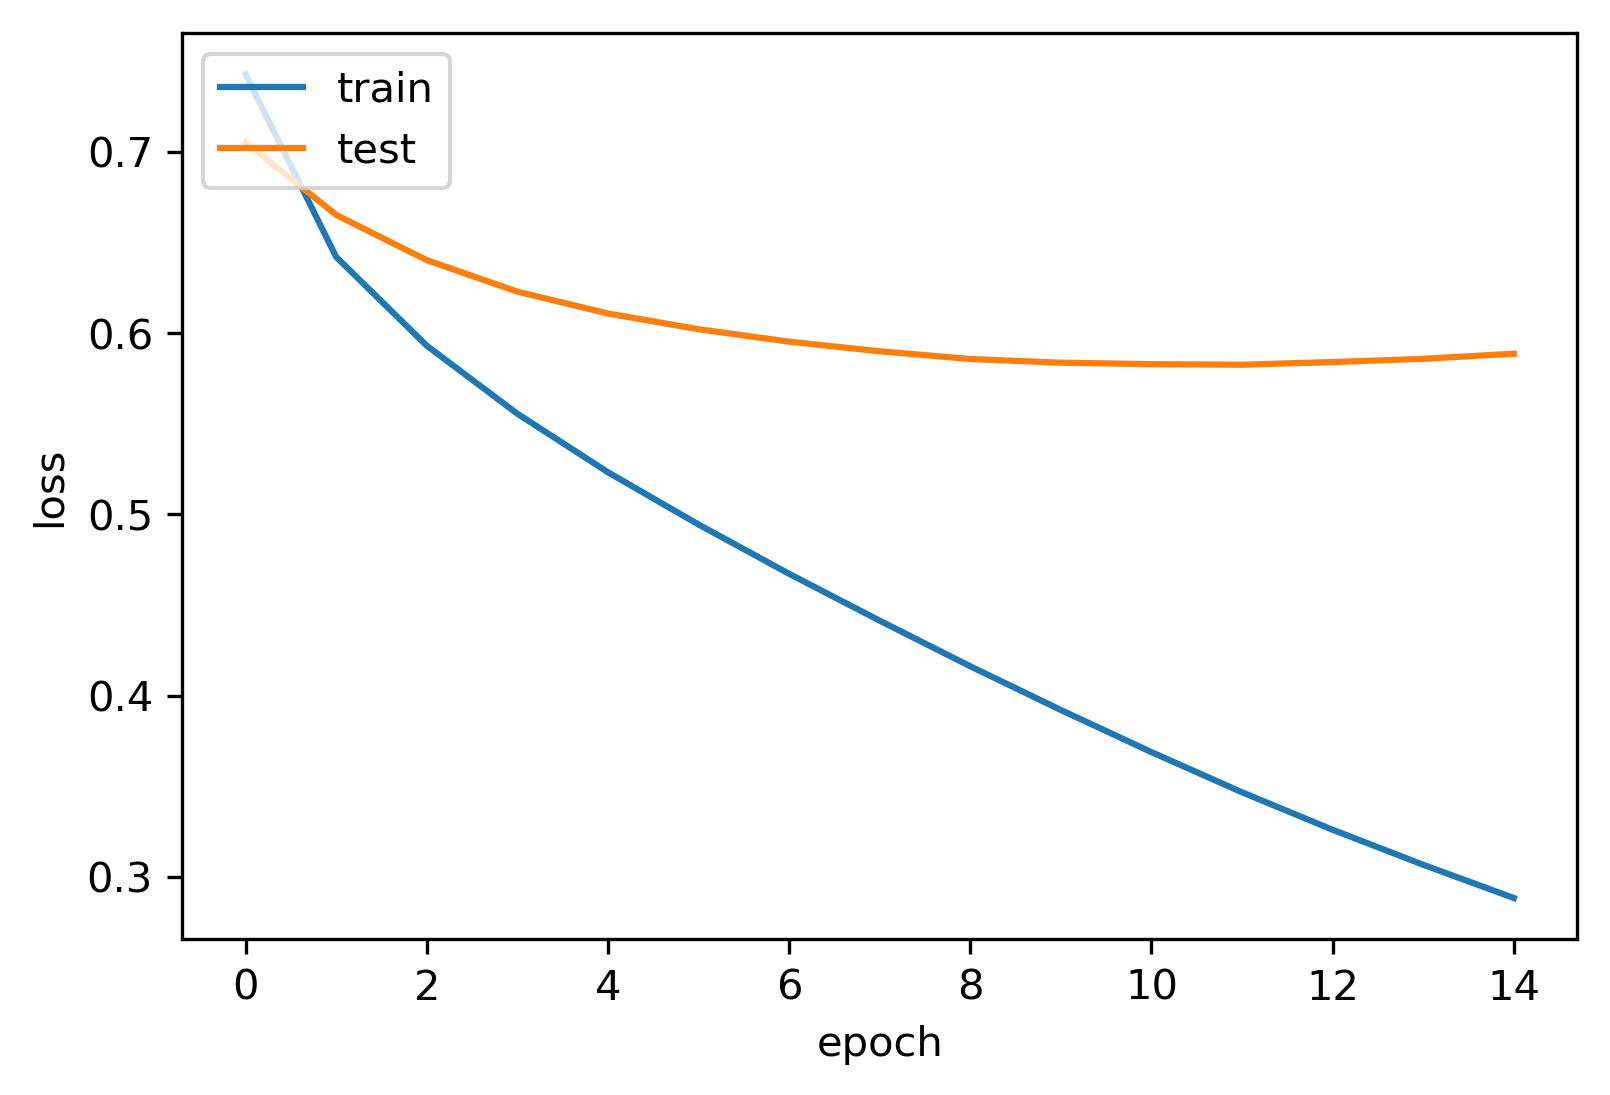

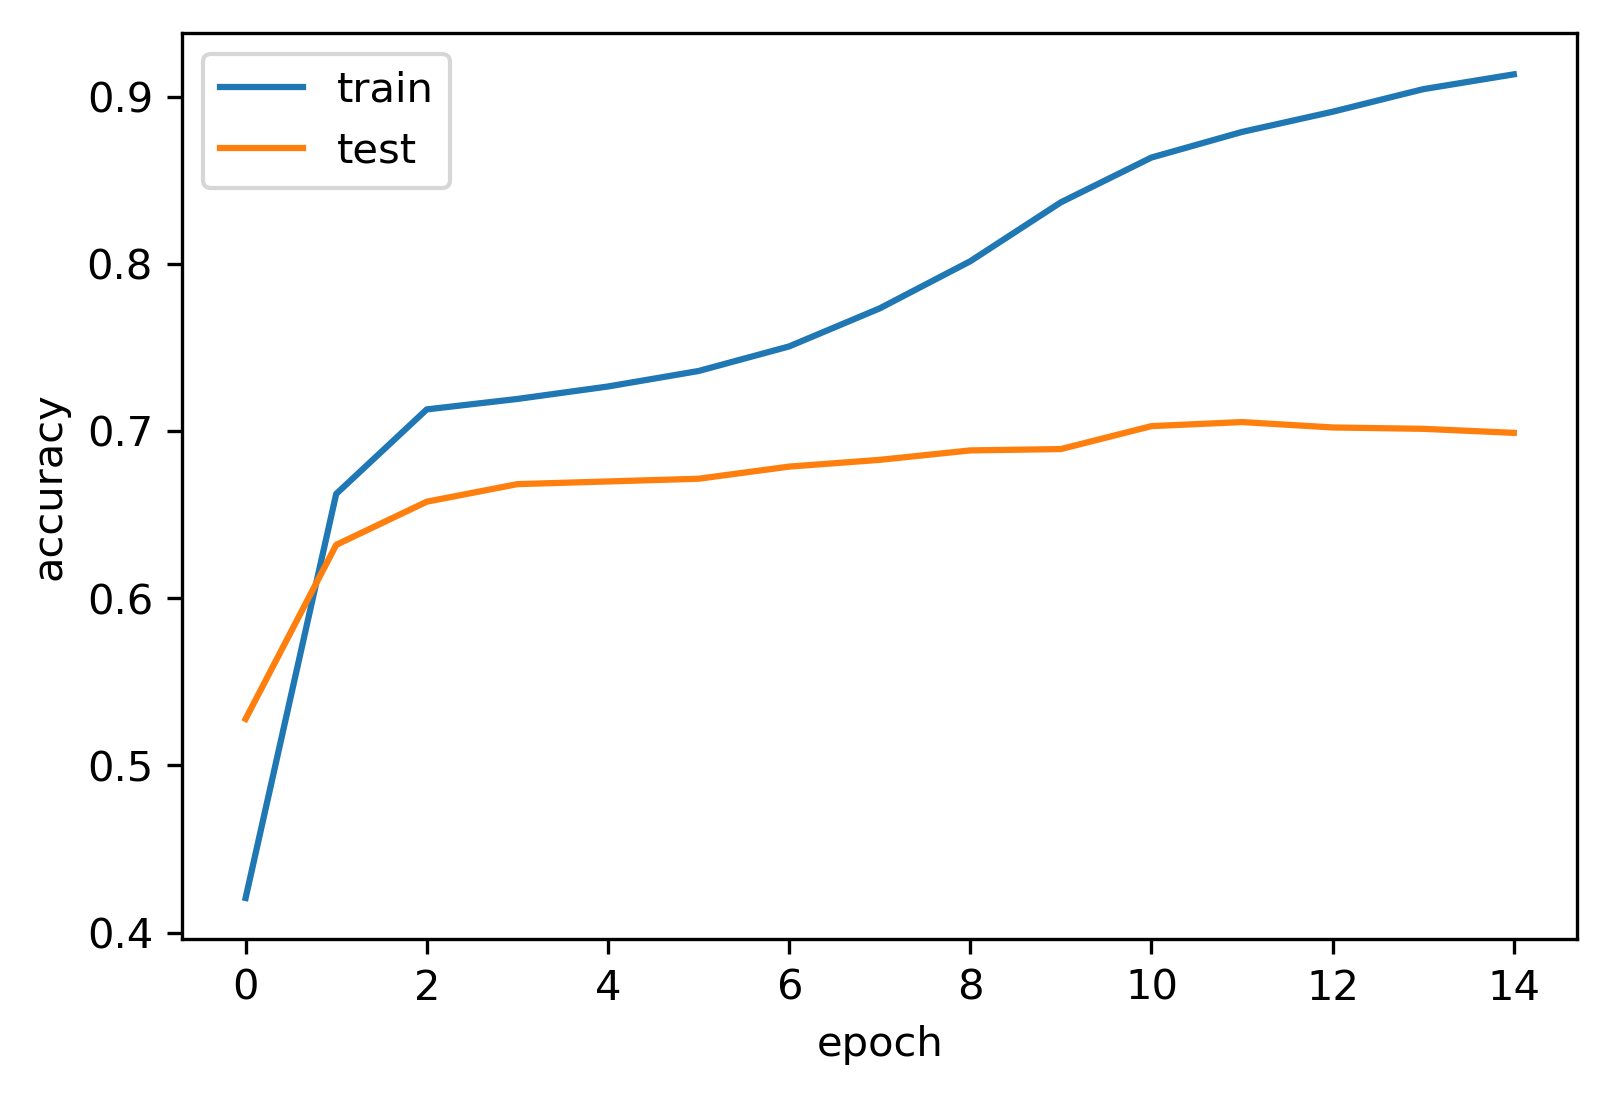

Testing dense model with layers: [100, 100]
Trained for 6 epochs
loss: 0.6322, binary_accuracy: 0.6651, mean_squared_error: 0.2153, precision: 0.4641, recall: 0.3727, fmeasure: 0.3951
Trained for 6 epochs
loss: 0.6522, binary_accuracy: 0.6530, mean_squared_error: 0.2218, precision: 0.4232, recall: 0.3067, fmeasure: 0.3331
Trained for 7 epochs
loss: 0.6059, binary_accuracy: 0.6900, mean_squared_error: 0.2025, precision: 0.4747, recall: 0.3905, fmeasure: 0.4084
Trained for 6 epochs
loss: 0.6035, binary_accuracy: 0.7078, mean_squared_error: 0.2021, precision: 0.5145, recall: 0.4173, fmeasure: 0.4502
Trained for 7 epochs
loss: 0.5922, binary_accuracy: 0.6941, mean_squared_error: 0.2014, precision: 0.4389, recall: 0.3898, fmeasure: 0.3995
loss: 0.6172 (+/-0.0219), binary_accuracy: 0.6820 (+/-0.0200), mean_squared_error: 0.2086 (+/-0.0084), precision: 0.4631 (+/-0.0315), recall: 0.3754 (+/-0.0372), fmeasure: 0.3973 (+/-0.0376)


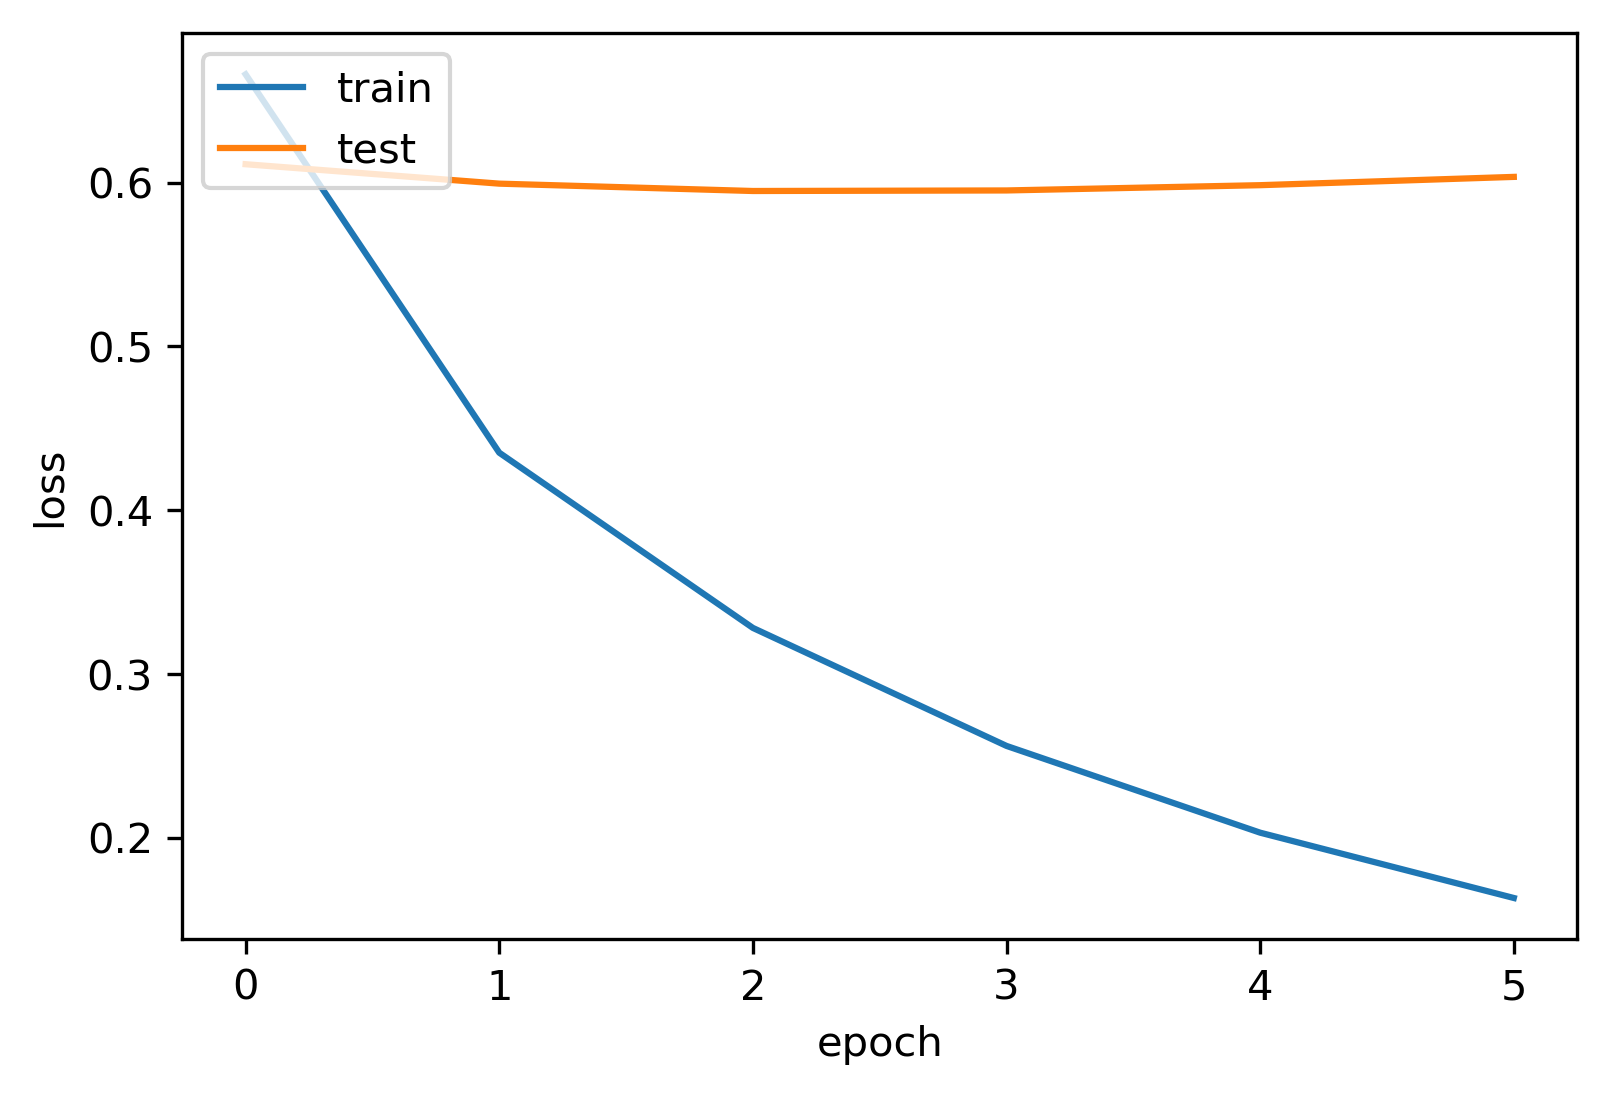

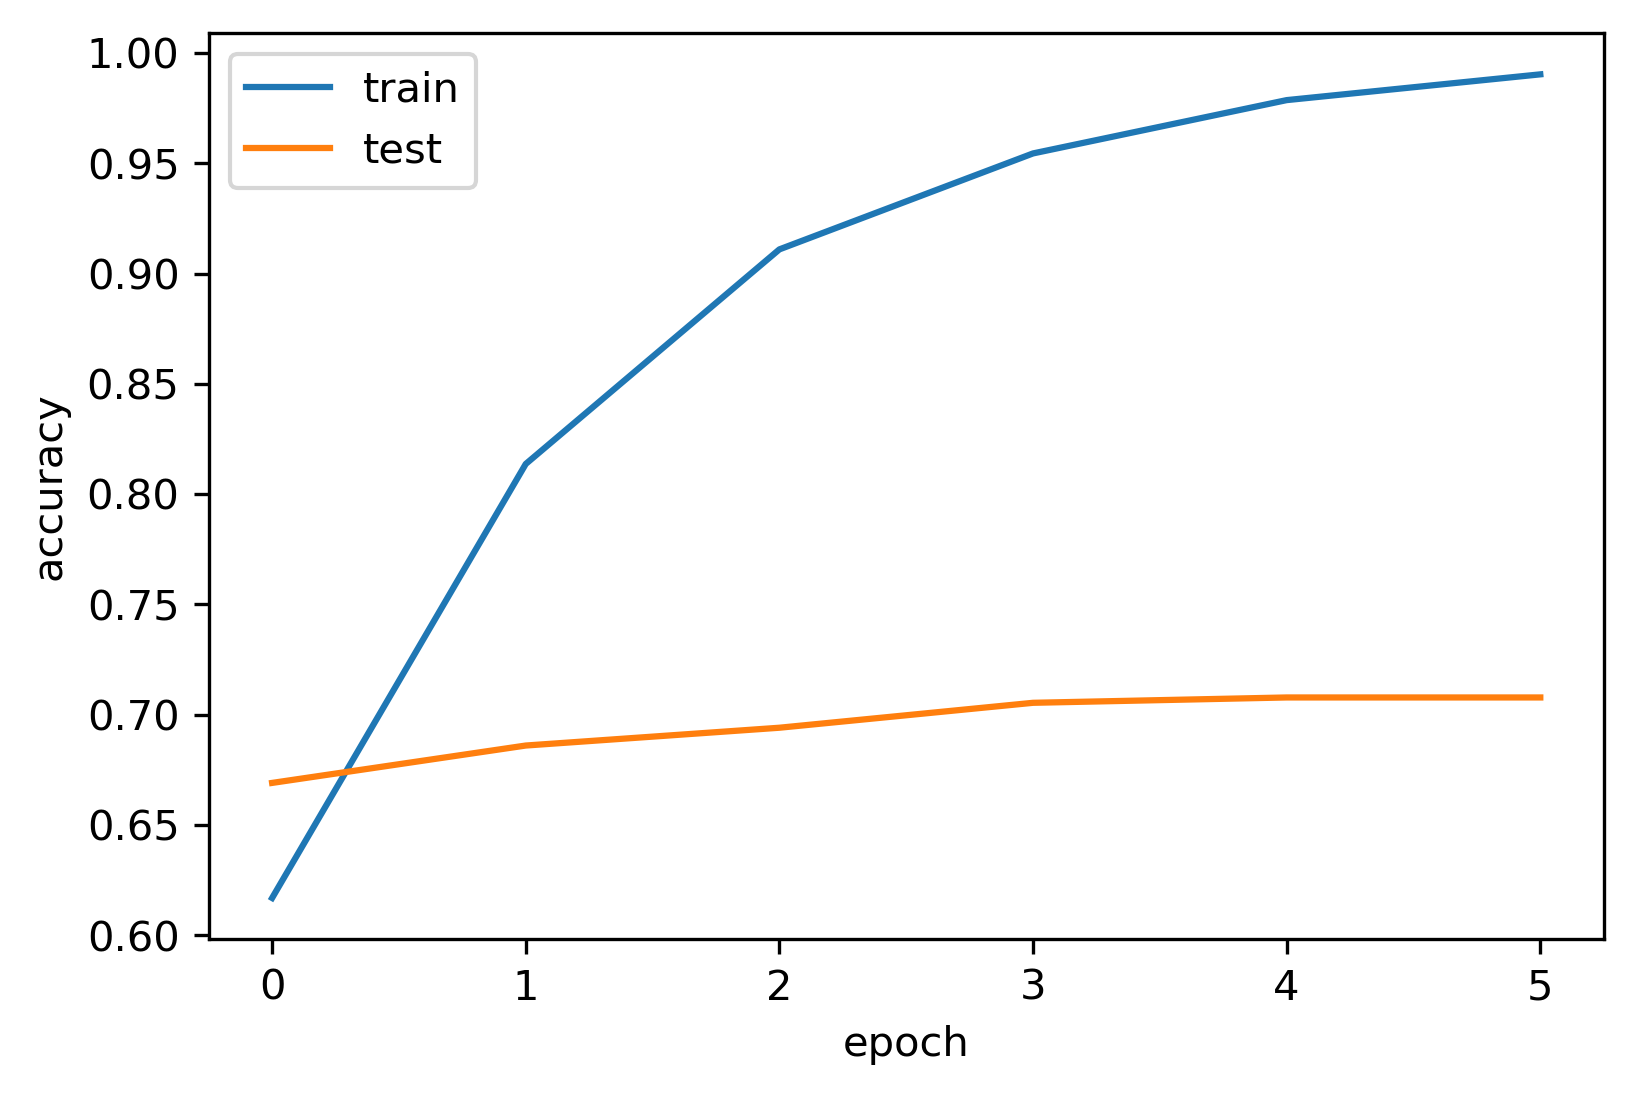

Testing dense model with layers: [100, 200, 100]
Trained for 7 epochs
loss: 0.5937, binary_accuracy: 0.6771, mean_squared_error: 0.2017, precision: 0.4978, recall: 0.3454, fmeasure: 0.3819
Trained for 7 epochs
loss: 0.5937, binary_accuracy: 0.6981, mean_squared_error: 0.2002, precision: 0.5332, recall: 0.2838, fmeasure: 0.3620
Trained for 6 epochs
loss: 0.5813, binary_accuracy: 0.6884, mean_squared_error: 0.1986, precision: 0.4931, recall: 0.3406, fmeasure: 0.3912
Trained for 8 epochs
loss: 0.5720, binary_accuracy: 0.6844, mean_squared_error: 0.1944, precision: 0.4828, recall: 0.3474, fmeasure: 0.3937
Trained for 8 epochs
loss: 0.5590, binary_accuracy: 0.7022, mean_squared_error: 0.1895, precision: 0.4561, recall: 0.3678, fmeasure: 0.3891
loss: 0.5799 (+/-0.0133), binary_accuracy: 0.6900 (+/-0.0091), mean_squared_error: 0.1969 (+/-0.0045), precision: 0.4926 (+/-0.0249), recall: 0.3370 (+/-0.0282), fmeasure: 0.3836 (+/-0.0115)


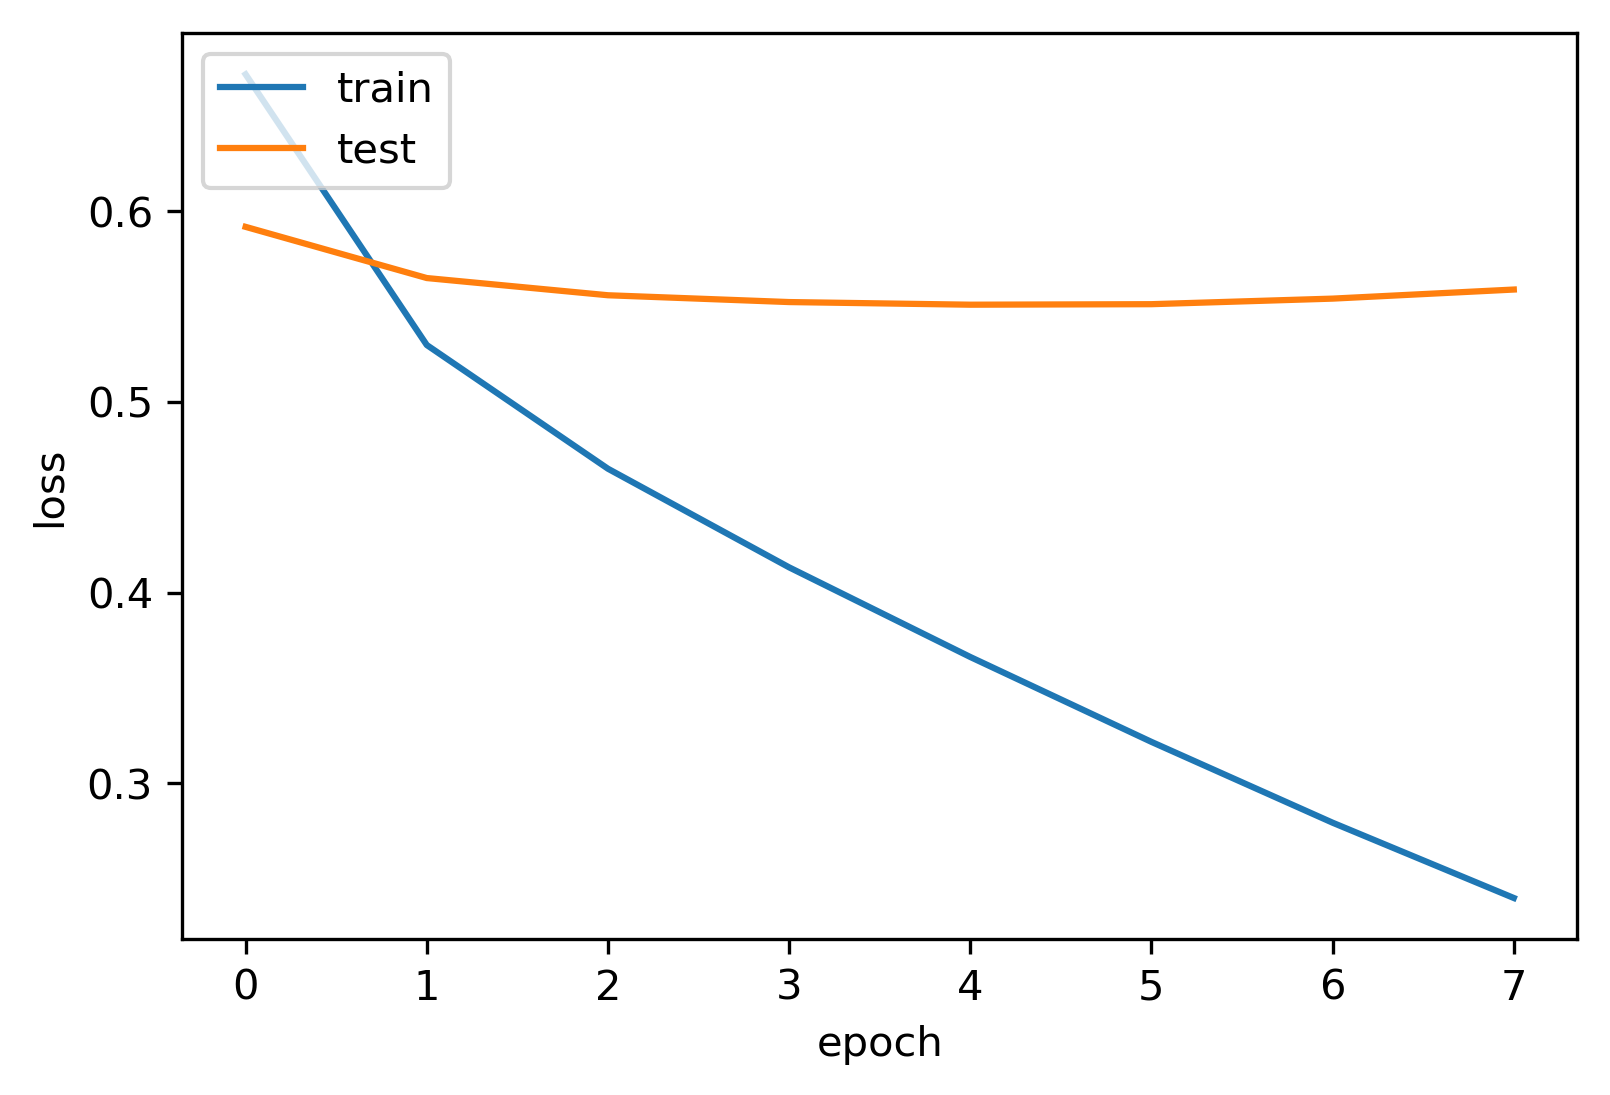

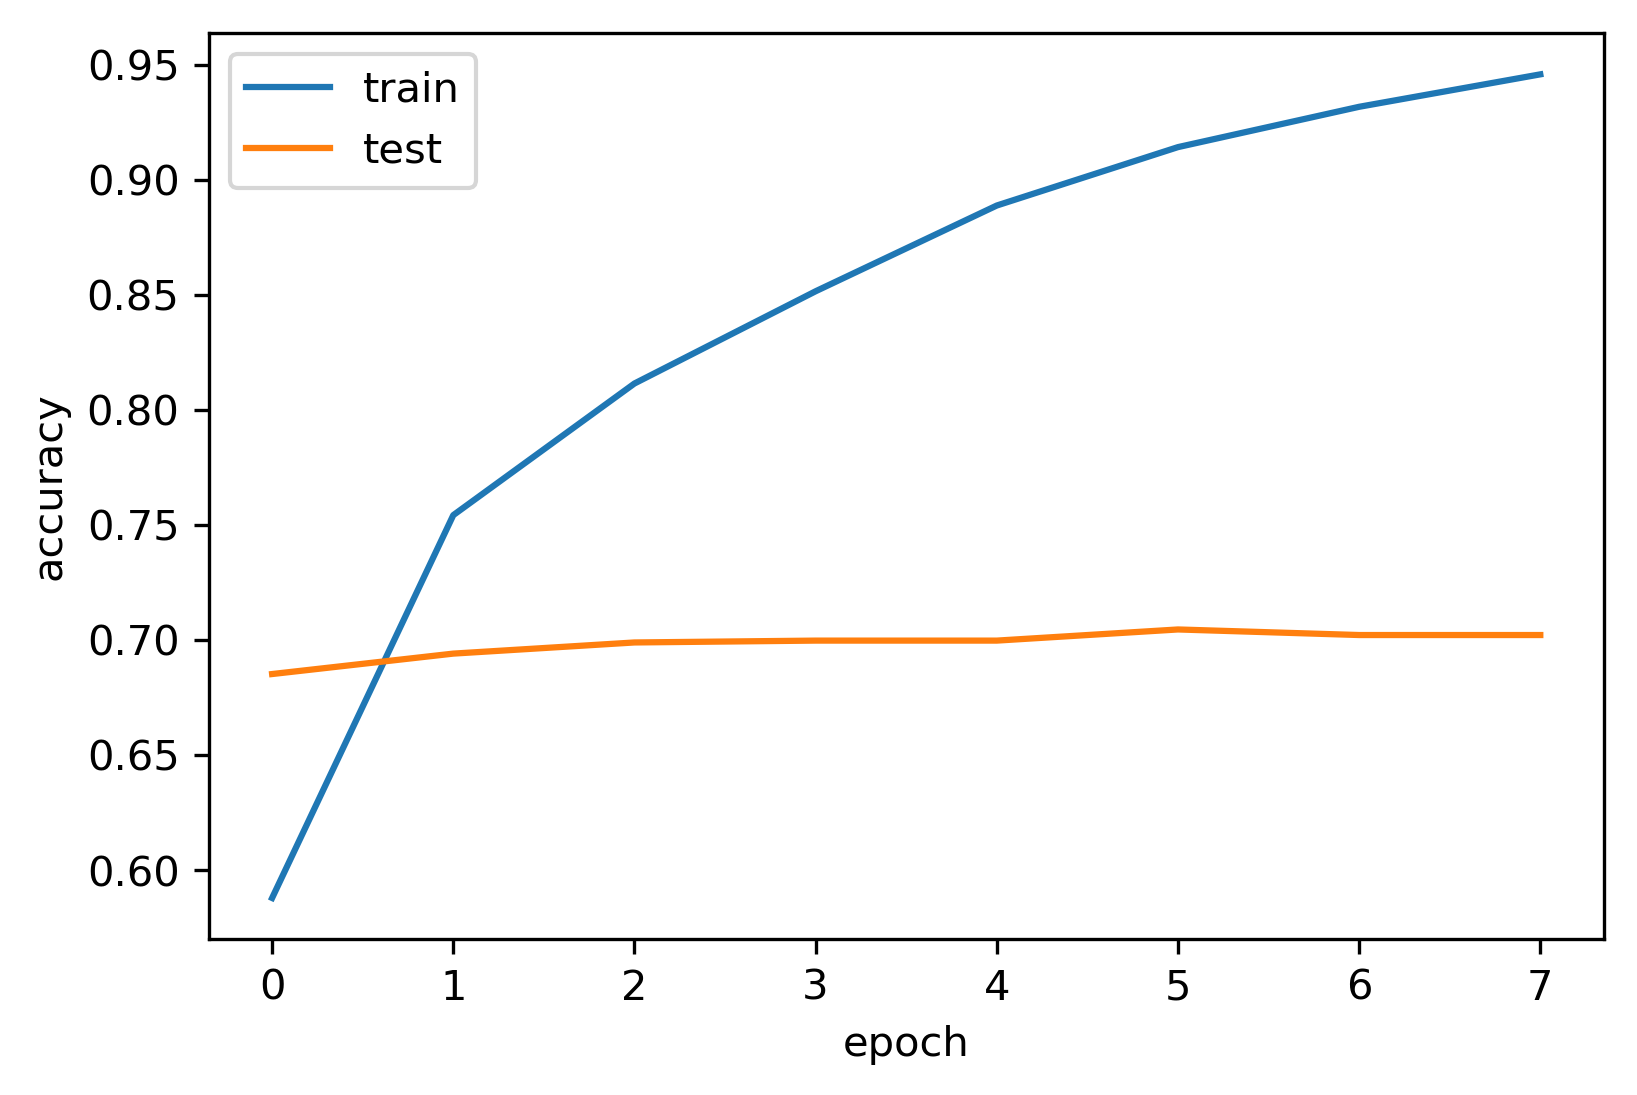

In [9]:
import itertools

considered_widths = [
    [10, 50, 10],
    [100, 100],
    [100, 200, 100]
]

for widths in considered_widths:
    print('Testing dense model with layers: {}'.format(widths))
    filename = network_name('dense_' + '_'.join([str(w) for w in widths]))
    simple_trained = tester.test_model(dense_network(widths), max_epochs=50)
    # Dense networks have very poor results and easily overfit - we disable saving them
    simple_trained.save(filename)

Test convolutional network with parameters {'pool': 16, 'layers': [(4, 16), (16, 16)]}:
Trained for 21 epochs
loss: 0.3840, binary_accuracy: 0.8035, mean_squared_error: 0.1249, precision: 0.6611, recall: 0.7316, fmeasure: 0.6902
Trained for 21 epochs
loss: 0.4030, binary_accuracy: 0.8221, mean_squared_error: 0.1306, precision: 0.8074, recall: 0.5359, fmeasure: 0.6338
Trained for 20 epochs
loss: 0.3718, binary_accuracy: 0.8414, mean_squared_error: 0.1178, precision: 0.8981, recall: 0.5396, fmeasure: 0.6528
Trained for 32 epochs
loss: 0.3498, binary_accuracy: 0.8701, mean_squared_error: 0.1077, precision: 0.7755, recall: 0.7904, fmeasure: 0.7736
Trained for 28 epochs
loss: 0.3344, binary_accuracy: 0.8539, mean_squared_error: 0.1062, precision: 0.8645, recall: 0.5142, fmeasure: 0.6337
loss: 0.3686 (+/-0.0243), binary_accuracy: 0.8382 (+/-0.0234), mean_squared_error: 0.1174 (+/-0.0095), precision: 0.8013 (+/-0.0821), recall: 0.6223 (+/-0.1151), fmeasure: 0.6768 (+/-0.0526)


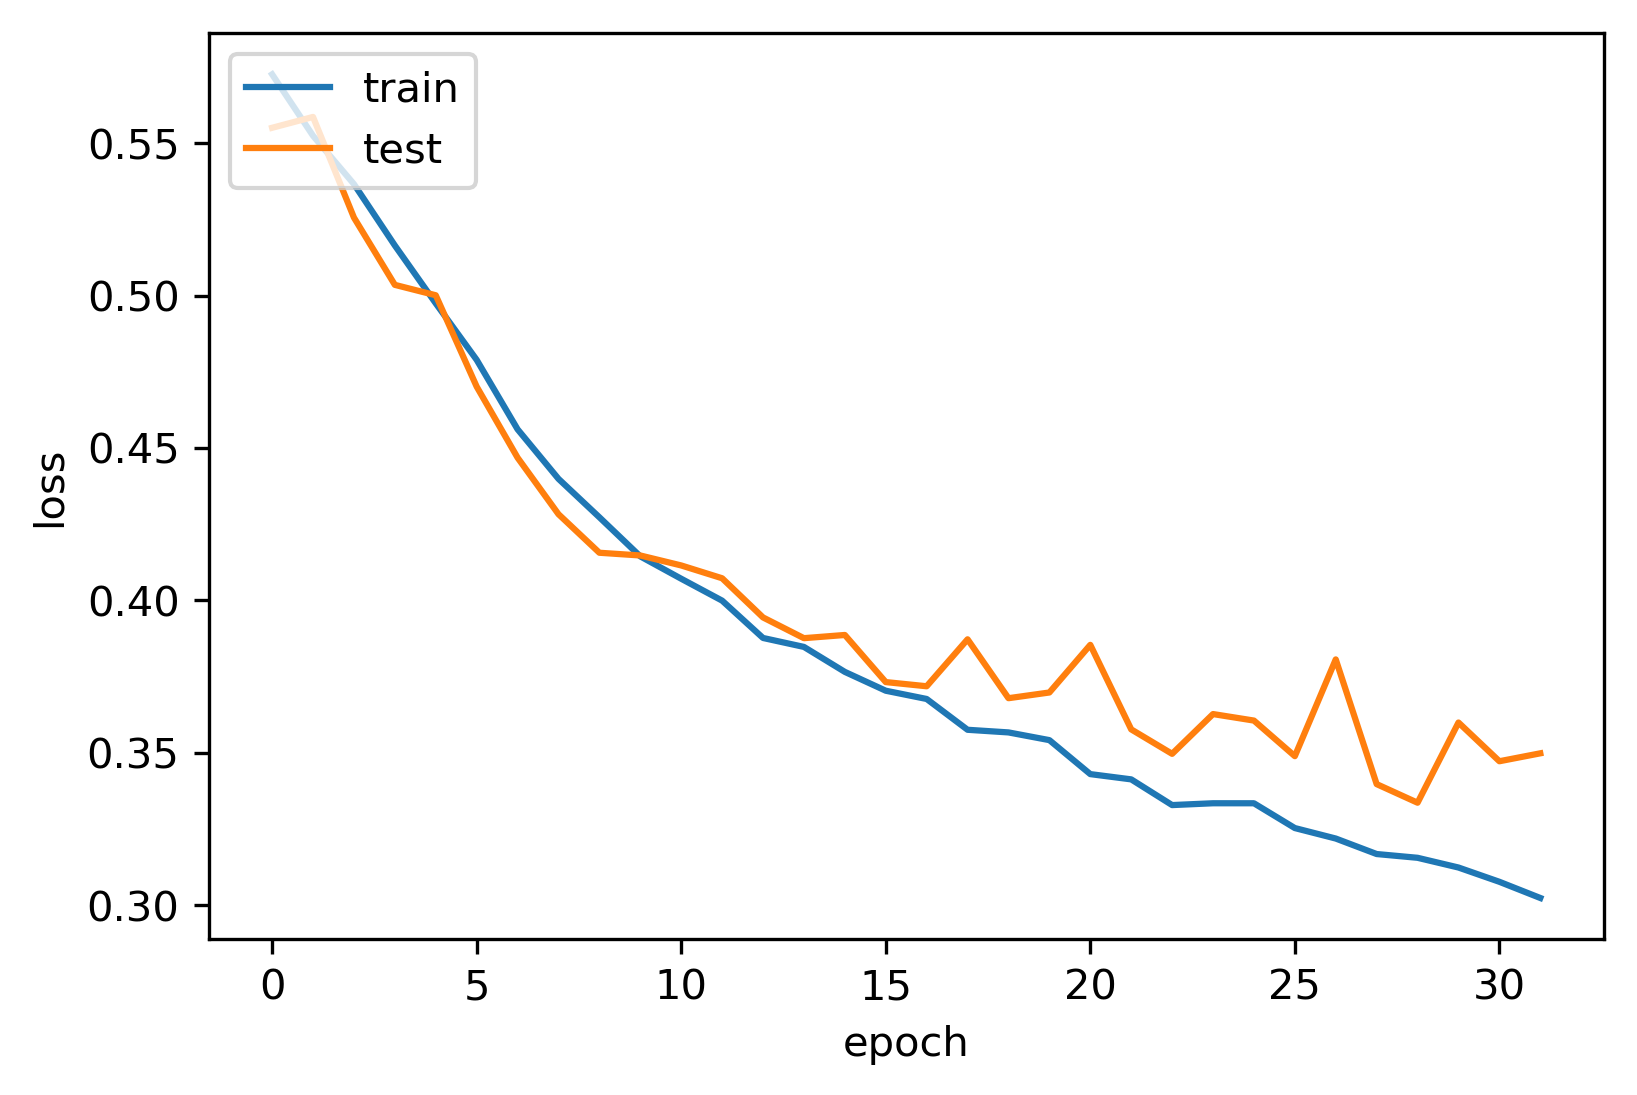

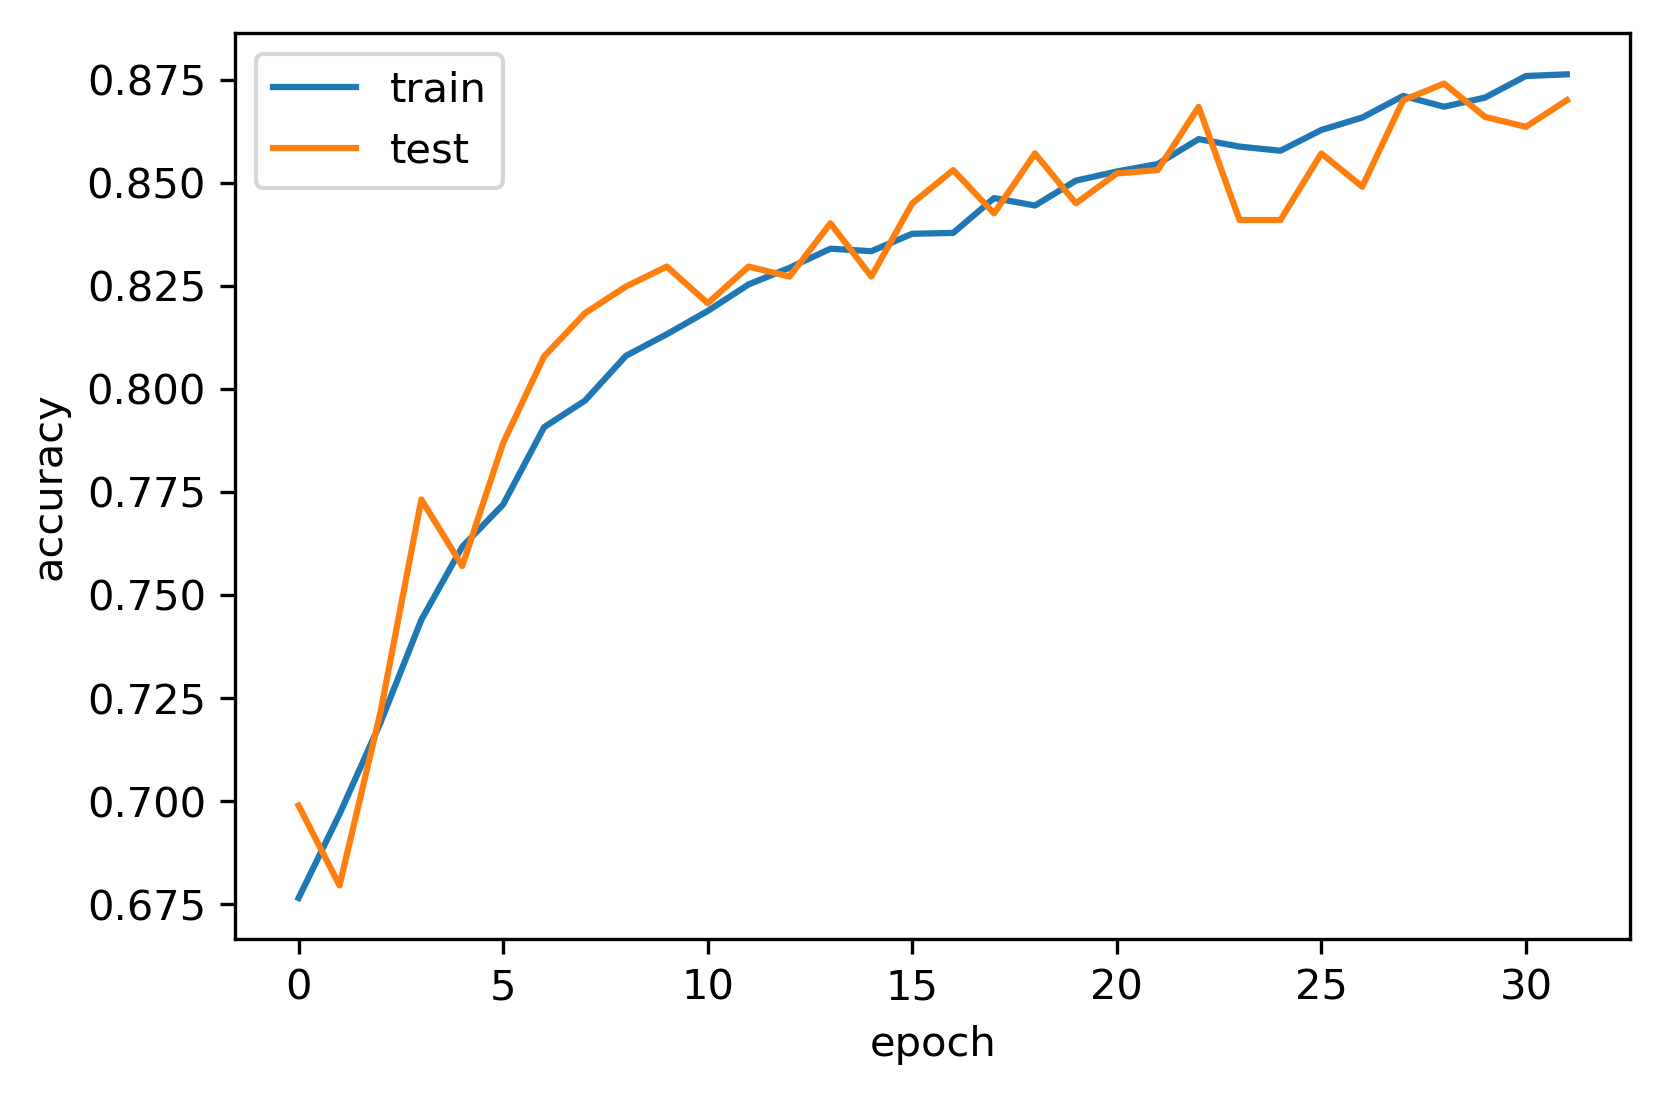

Test convolutional network with parameters {'pool': 16, 'layers': [(32, 16), (16, 16)]}:
Trained for 34 epochs
loss: 0.2995, binary_accuracy: 0.8671, mean_squared_error: 0.0940, precision: 0.9014, recall: 0.6485, fmeasure: 0.7408
Trained for 14 epochs
loss: 0.4202, binary_accuracy: 0.8092, mean_squared_error: 0.1369, precision: 0.7370, recall: 0.6253, fmeasure: 0.6613
Trained for 29 epochs
loss: 0.3146, binary_accuracy: 0.8631, mean_squared_error: 0.0957, precision: 0.8983, recall: 0.6232, fmeasure: 0.7246
Trained for 14 epochs
loss: 0.3873, binary_accuracy: 0.8345, mean_squared_error: 0.1194, precision: 0.9116, recall: 0.5024, fmeasure: 0.6267
Trained for 31 epochs
loss: 0.4225, binary_accuracy: 0.7732, mean_squared_error: 0.1434, precision: 0.5416, recall: 0.8950, fmeasure: 0.6532
loss: 0.3688 (+/-0.0522), binary_accuracy: 0.8294 (+/-0.0351), mean_squared_error: 0.1178 (+/-0.0204), precision: 0.7980 (+/-0.1436), recall: 0.6589 (+/-0.1287), fmeasure: 0.6813 (+/-0.0438)


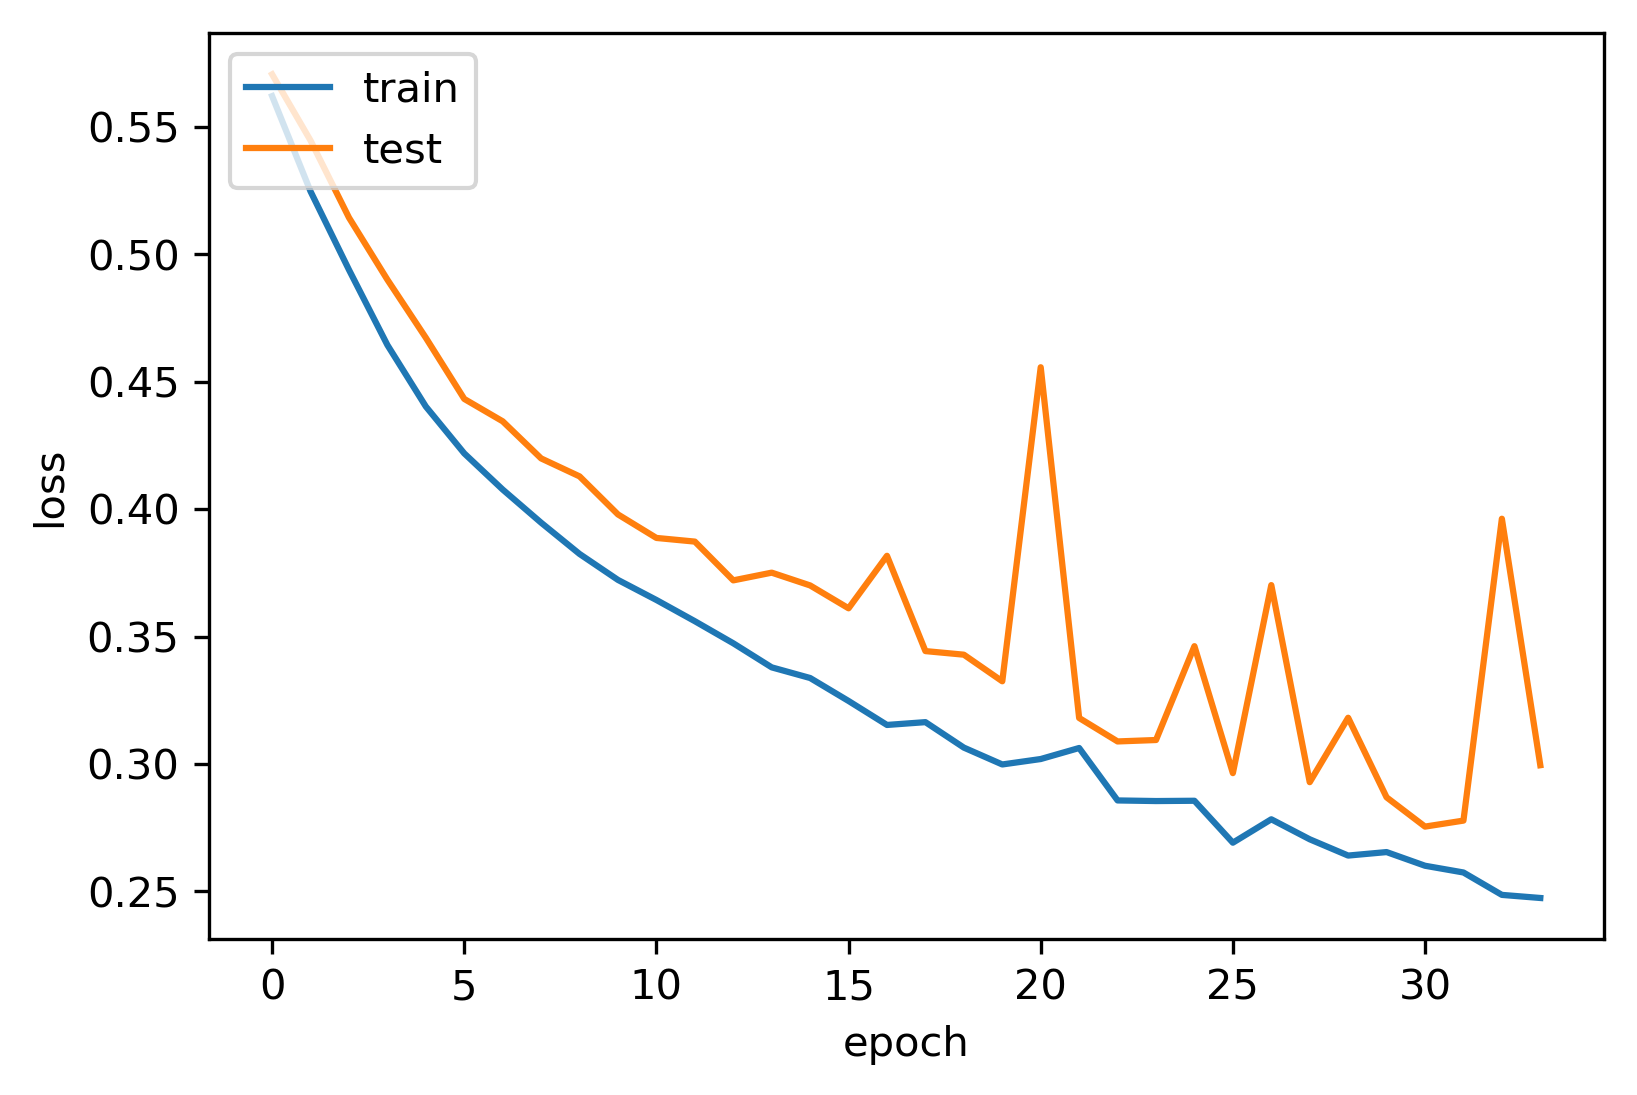

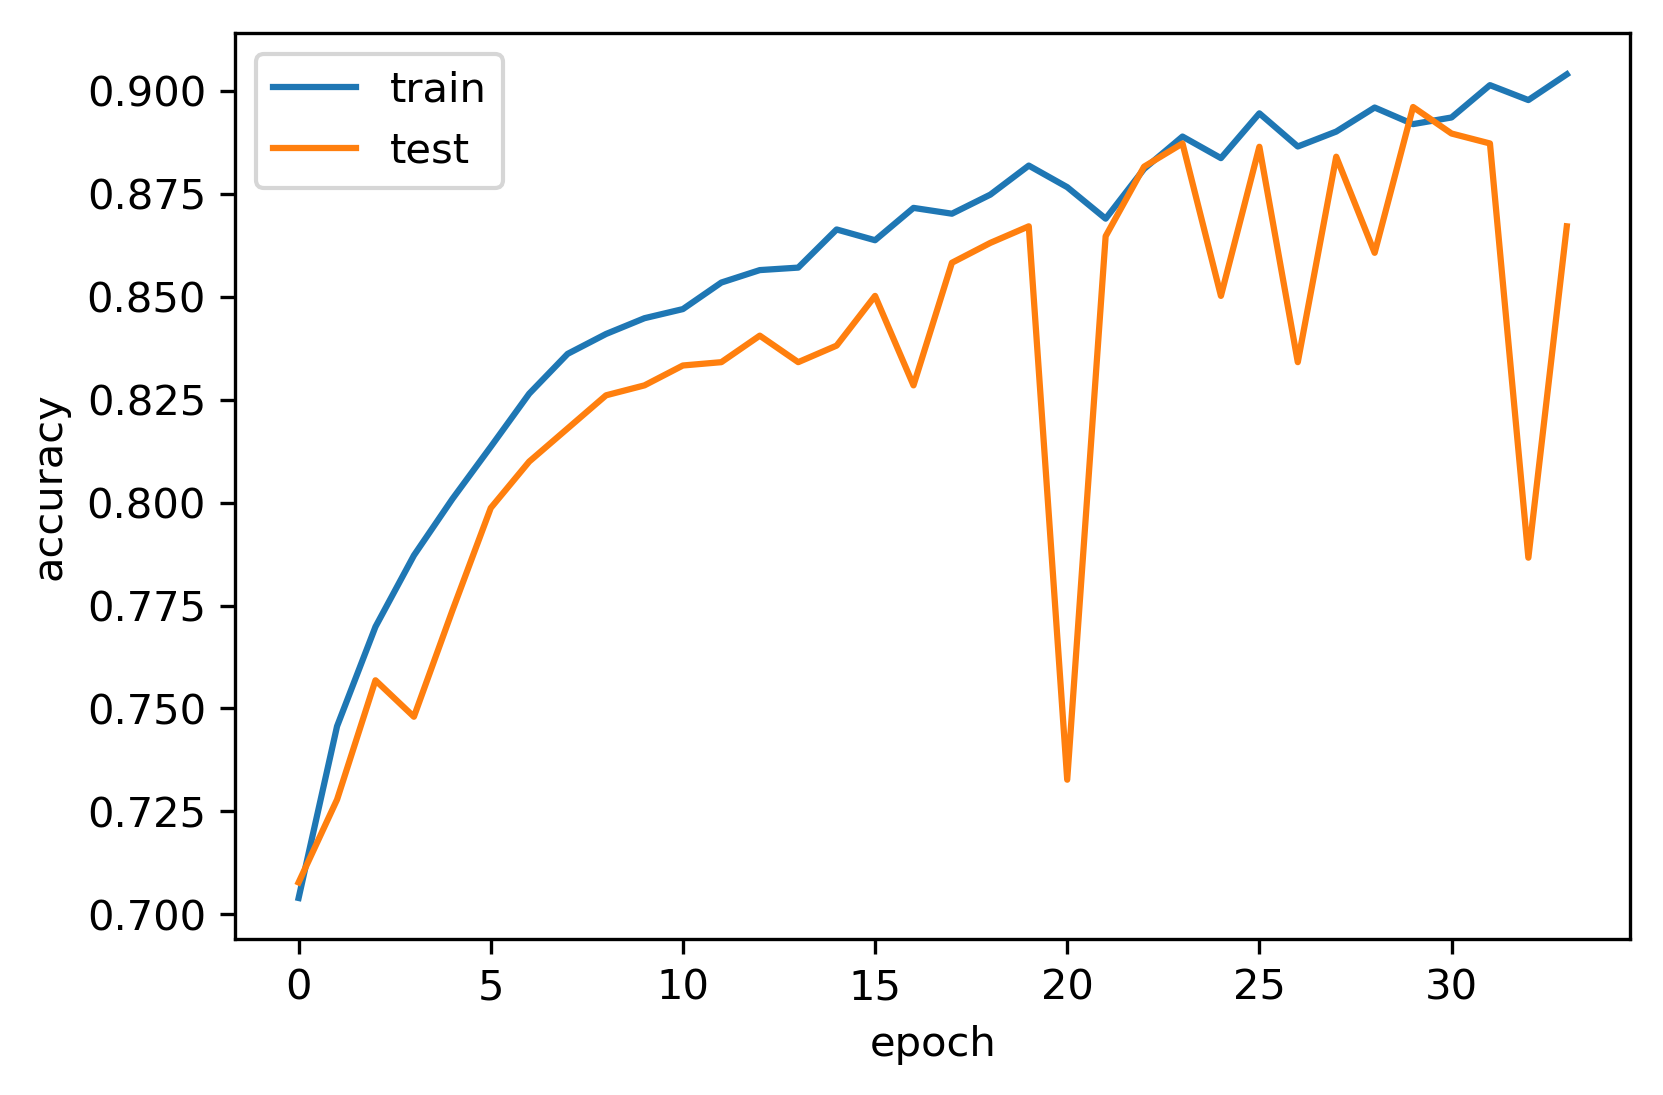

Test convolutional network with parameters {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]}:
Trained for 28 epochs
loss: 0.3651, binary_accuracy: 0.8446, mean_squared_error: 0.1158, precision: 0.8708, recall: 0.5727, fmeasure: 0.6741
Trained for 16 epochs
loss: 0.4130, binary_accuracy: 0.7995, mean_squared_error: 0.1368, precision: 0.7495, recall: 0.5229, fmeasure: 0.5997
Trained for 15 epochs
loss: 0.4119, binary_accuracy: 0.8027, mean_squared_error: 0.1351, precision: 0.7950, recall: 0.4428, fmeasure: 0.5279
Trained for 27 epochs
loss: 0.3340, binary_accuracy: 0.8725, mean_squared_error: 0.1002, precision: 0.9149, recall: 0.6331, fmeasure: 0.7292
Trained for 40 epochs
loss: 0.2646, binary_accuracy: 0.8910, mean_squared_error: 0.0790, precision: 0.7846, recall: 0.7136, fmeasure: 0.7419
loss: 0.3577 (+/-0.0553), binary_accuracy: 0.8421 (+/-0.0366), mean_squared_error: 0.1134 (+/-0.0218), precision: 0.8229 (+/-0.0607), recall: 0.5770 (+/-0.0925), fmeasure: 0.6546 (+/-0.0808)


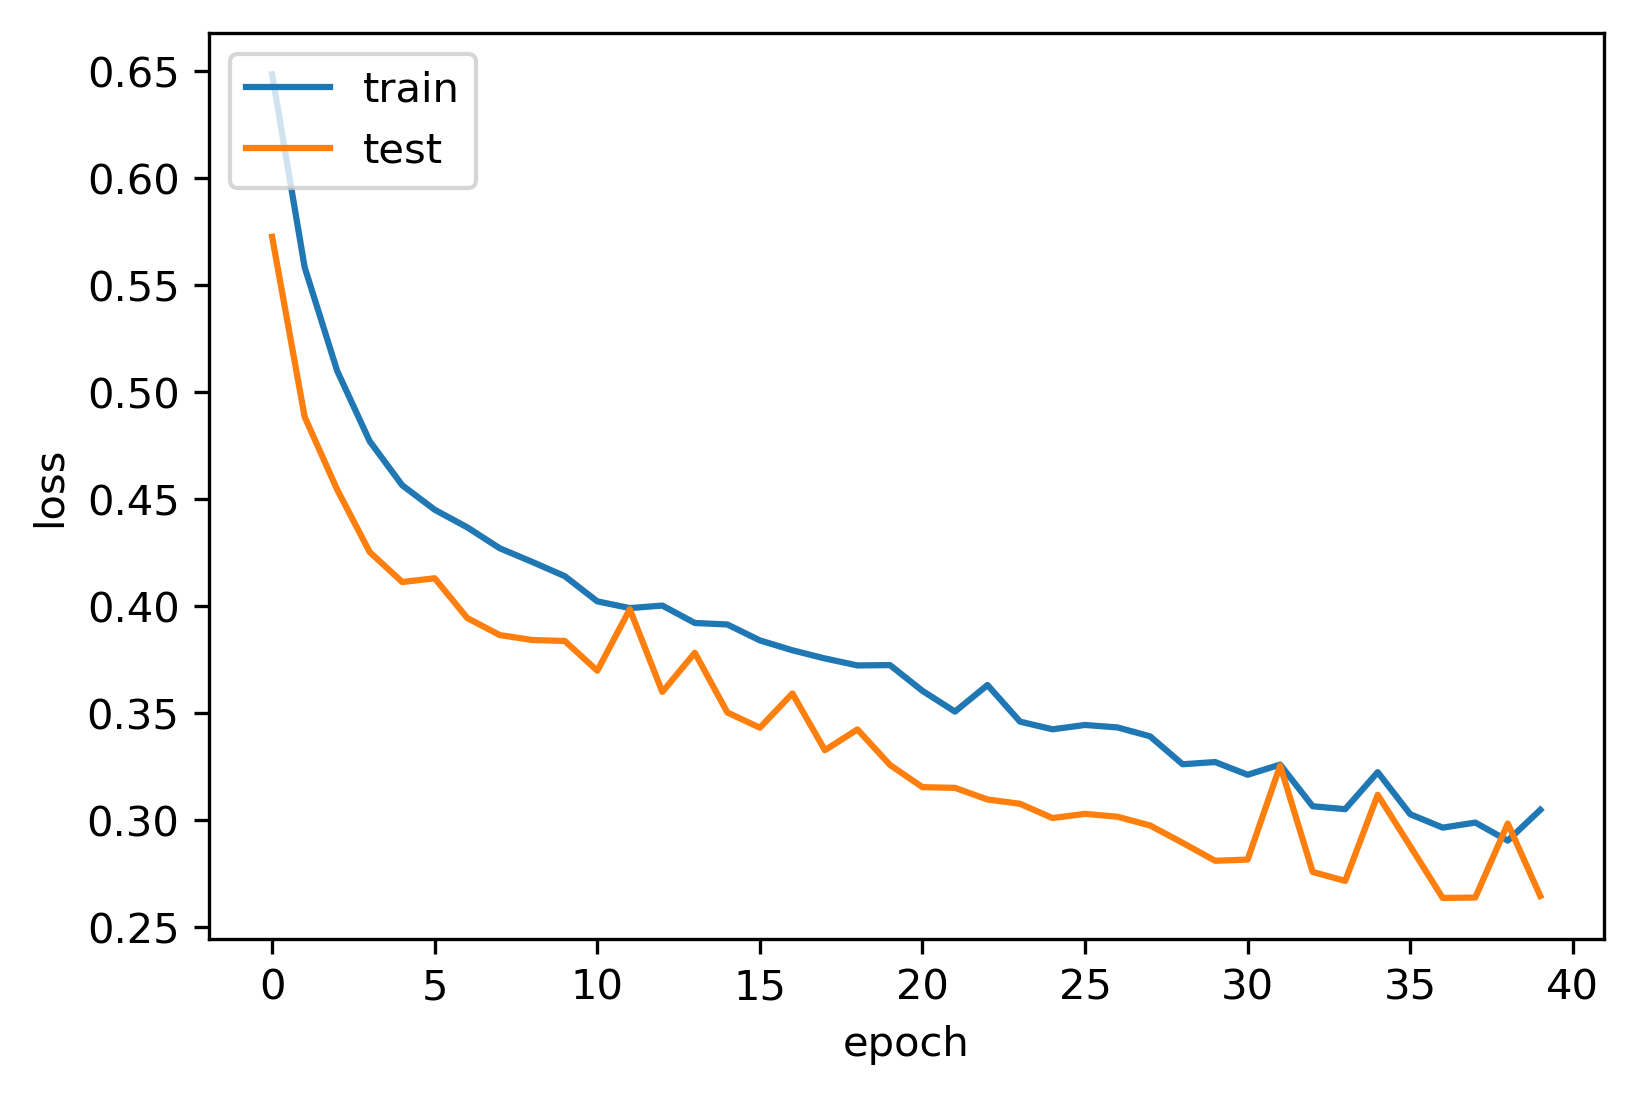

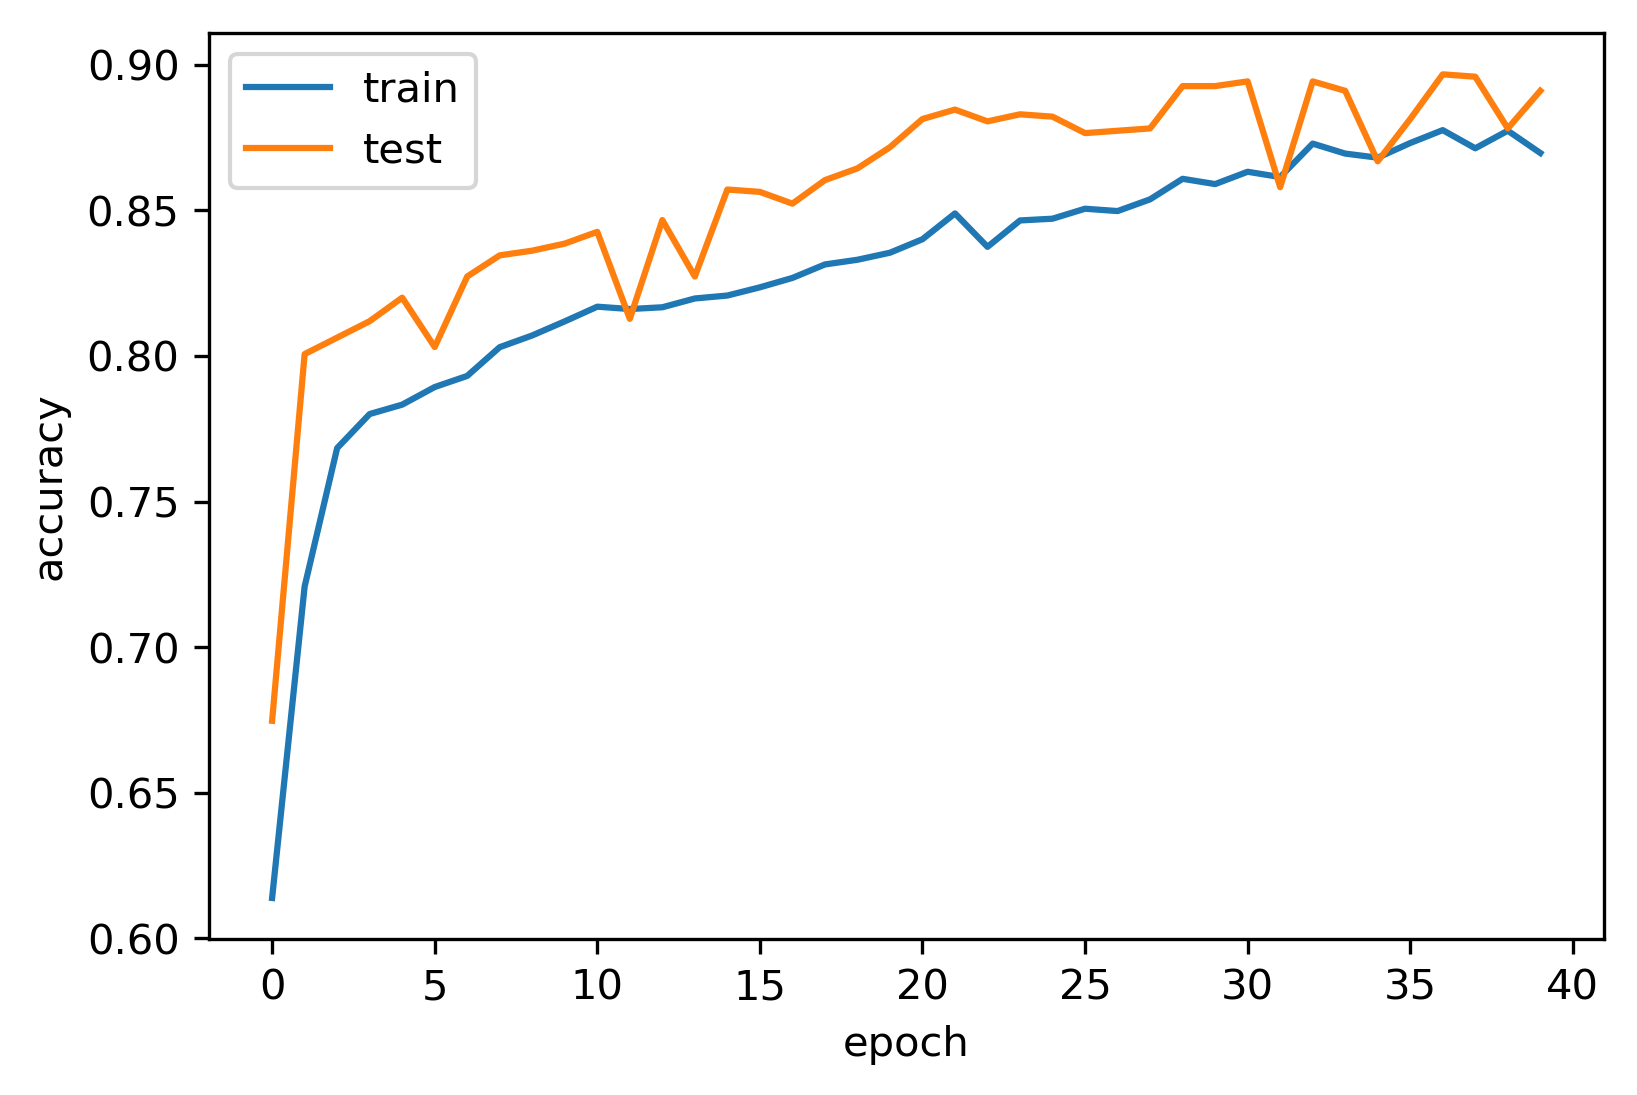

In [10]:
considered_variants = [
    {'pool': 16, 'layers': [(4, 16), (16, 16)]},
    {'pool': 16, 'layers': [(32, 16), (16, 16)]},
    {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]},
]

for i, variant in enumerate(considered_variants):
    print("Test convolutional network with parameters {}:".format(variant))
    filename = network_name('conv_' + str(i))
    trained = tester.test_model(conv_network(**variant), max_epochs=50)
    trained.save(filename)